In [ ]:
# import subprocess

# packages = ['geemap', 'geopandas',
#             'shapely', 'requests', 
#             'osgeo', 'rasterio', 'numpy',
#             'sklearn', 'fiona', 'pyproj',
#             'matplotlib', 'pandas',
#             'seaborn','geocube', 'os']

# for package in packages:
#     try:
#         __import__(package)
#     except ImportError:
#         subprocess.check_call(['pip', 'install', package])

import neccessary libaries

In [37]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import rasterio as rio
import shapely
import fiona

In [42]:
# load the boundary shapefile for Area of Intrest (AOI)
study_area = gpd.read_file('Matto_Grosso.shp')
study_area.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,33,BRA,Brazil,12,MT,Estado,State,None,Matto Grosso,"POLYGON ((-57.60524 -8.66285, -57.59355 -8.707..."


### The independent variables that will be use in building this model are in raster format, they will be extracted from google earth engine and downloaded uisng geemap and ee API.

In [ ]:
# import google eath enigne libary for python
import io
import geemap
import ee

In [ ]:
# Autheticate the Google earth engine ee login
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

Define ee boundary

In [ ]:
# convert the boundary shapefile to ESPG 4326
boundary = study_area

import json

# define a helper function to put the geodataframe in the right format for constructing an ee object
def shp_to_ee_fmt(geodf):
    data = json.loads(geodf.to_json())
    return data['features'][0]['geometry']['coordinates']

# create the ee object
feature_cls = ee.Geometry.MultiPolygon(shp_to_ee_fmt(boundary))

Generate Slope and DEM

In [ ]:
#load SRTM data from google earth engine
srtm = ee.Image('CGIAR/SRTM90_V4')

# Generate individual raster data
elevation = srtm.select('elevation')
slope = ee.Terrain.slope(elevation)

Generate LULC

In [ ]:
collection = (
    ee.ImageCollection('ESA/WorldCover/v200')
    .filterBounds(feature_cls)
)
landuse = collection.aggregate_array('system:index').getInfo()

image = collection.first()
# load ESA 2020 World wide 10m land cover  data form google earth 

In [ ]:
#load SRTM data from google earth engine
srtm = ee.Image('CGIAR/SRTM90_V4')


# Generate slope and elevation data from srtm
elevation = srtm.select('elevation')
slope = ee.Terrain.slope(elevation)


# load ESA 2020 World wide 10m land cover  data form google earth engine catalog
collection = (
    ee.ImageCollection('ESA/WorldCover/v200')
    .filterBounds(feature_cls)
)

# select the lulc file from the collection
landuse = collection.first()


# GENERATE TEMPERATURE AND RAINFALL DATASET
# Define date range
start_date = '2012-01-01'
end_date = '2022-12-31'

# Load CHIRP precipitation data
rainfall = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterBounds(feature_cls) \
    .filterDate(start_date, end_date) \
    .select('precipitation') \
    .sum()

# Load average temperature data
temp = ee.ImageCollection('NOAA/CFSV2/FOR6H') \
    .filterBounds(feature_cls) \
    .filterDate(start_date, end_date) \
    .select('Temperature_height_above_ground') \
    .mean()


# select Landsat 8 collection for the spectal indices
l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA") \
    .filterBounds(feature_cls) \
    .filterDate('2021-01-01', '2022-12-31') \
    .sort('CLOUD_COVER') \
    .median()


# Calculate NDVI
ndvi = l8.normalizedDifference(['B5', 'B4'])

# Calculate BSI
bsi = l8.expression(
    '((SWIR2 + RED) - (SWIR1 + NIR)) / ((SWIR2 + RED) + (SWIR1 + NIR))',
    {
        'SWIR1': l8.select('B6'),
        'SWIR2': l8.select('B6'),
        'NIR': l8.select('B5'),
        'RED': l8.select('B4')
    }
)


# Global SOC soil dataset
soil = ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02")\
        .select('b30')\
        



# clip all the images load to the study area
elevation_clip  = elevation.clip(feature_cls)
slope_clip = slope.clip(feature_cls)
landcover_clip = landuse.clip(feature_cls)
rainfall_clip = rainfall.clip(feature_cls)
temp_clip = temp.clip(feature_cls)
ndvi_clip = ndvi.clip(feature_cls)
bsi_clip = bsi.clip(feature_cls)
soil_clip = soil.clip(feature_cls)

set Visualization Parameters

In [ ]:

# visualization parameters
elevation_viz = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}

slope_viz = {
    'min': 0,
    'max': 60,
    'palette': ['brown', 'yellow', 'green']
}

landcover_viz = {
  'min': 0,
  'max': 100,
  'palette': [
      'FC6D26', 'FCAF17', 'E8EB45', '34B334', '4C7EAF',
      'B05AFF', 'A56F37', '914D25', 'BFC0C3', 'FFFFFF',
  ]
}

rainfall_viz = {
    'min': 0,
    'max': 300,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}


temp_viz = {
    'min': 0,
    'max': 310.0,
    'palette': ['blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

ndvi_viz = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'yellow', 'green']
}


bsi_viz = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'yellow', 'green']
}


soil_viz = {
  'min': 0.0,
  'max': 120.0,
  'palette': [
    "ffffa0","f7fcb9","d9f0a3","addd8e","78c679","41ab5d",
    "238443","005b29","004b29","012b13","00120b",
  ]
};

Add Data to Map layer

In [ ]:
# Add all image layer to a basemap
Map.addLayer(elevation_clip, elevation_viz, 'Elevation')
Map.addLayer(slope_clip, slope_viz, 'Slope')
Map.addLayer(landcover_clip, landcover_viz, 'Landcover')
Map.addLayer(rainfall_clip, rainfall_viz, 'Rainfall')
Map.addLayer(temp_clip, temp_viz, 'Temperature')
Map.addLayer(ndvi_clip, ndvi_viz, 'NDVI')
Map.addLayer(bsi_clip, bsi_viz, 'BSI')
Map.addLayer(soil_clip, soil_viz,'Soil organic carbon content in x 5 g / kg')

# set map center object
Map.centerObject(elevation_clip, 8)


# call the geemap Map object
Map

Export Data

In [ ]:
cwd = os.getcwd()
print(cwd)
cell_size = 1000
geemap.ee_export_image(elevation_clip, os.path.join(cwd,'elevation.tif'), scale=cell_size,region=feature_cls)
geemap.ee_export_image(slope_clip, os.path.join(cwd,'slope.tif'), scale=cell_size,region=feature_cls)
geemap.ee_export_image(landcover_clip, os.path.join(cwd,'landcover.tif'), scale=cell_size, region=feature_cls)
geemap.ee_export_image(ndvi_clip, os.path.join(cwd,'ndvi.tif'), scale=cell_size, region=feature_cls)
geemap.ee_export_image(bsi_clip, os.path.join(cwd,'bsi.tif'), scale=cell_size, region=feature_cls)
geemap.ee_export_image(rainfall_clip, os.path.join(cwd,'rainfall.tif'), scale=cell_size,region=feature_cls)
geemap.ee_export_image(temp_clip, os.path.join(cwd,'temp.tif'), scale=cell_size,region=feature_cls)
geemap.ee_export_image(soil_clip, os.path.join(cwd,'soil.tif'), scale=cell_size,region=feature_cls)

Generate 3000 random points wihtin the study area boundary

In [ ]:
import random 
from shapely import Point
import json

def generate_random_points(boundary=None, num_points=None, crs=None):
    # Generate the random points within the shapefile boundary
    points = []
    while len(points) < num_points:
        # Generate a random point within the extent of the boundary
        x = random.uniform(boundary.bounds.minx, boundary.bounds.maxx)
        y = random.uniform(boundary.bounds.miny, boundary.bounds.maxy)
        point = Point(x, y)
        
        # Check if the point is within the boundary
        if point.within(boundary.geometry.values[0]):
            points.append(point)

    # Convert the list of points to a GeoDataFrame
    if crs is None:
        crs = boundary.crs
    random_points_gdf = gpd.GeoDataFrame(geometry=points, crs=crs)
    return random_points_gdf

def shp_to_ee_fmt(geodf):
    # define a helper function to put the geodataframe in the right format for constructing an ee object
    data = json.loads(geodf.to_json())
    return data['features'][0]['geometry']['coordinates']

def  get_value_to_point(point_data:gpd.GeoDataFrame, raster_dataset) -> gpd.GeoDataFrame:
    # Get the values of slope, elevation, and land use at the location of the random points
    for index, point in point_data.iterrows():
        # Get the coordinates of the point
        x = point.geometry.x
        y = point.geometry.y
        
        # Get the row and column indices of the point in the rasters
        row, col = raster_dataset.index(x, y)
        
        # Extract the values of slope, elevation, and land use at the location of the point
        point_value =  raster_dataset.read(1)[row, col]
       
        # Append the values to the point's attributes
        point_data.loc[index,os.path.basename(point_data)] = point_value
        
    # read the dataset to view the addeded columns
    return point_data

In [40]:
sampling_points.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2607 entries, 0 to 2606
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Year        2607 non-null   int64   
 1   Layer       2606 non-null   object  
 2   X           2607 non-null   float64 
 3   Y           2607 non-null   float64 
 4   Upper_dept  2607 non-null   object  
 5   Lower_dept  2607 non-null   int64   
 6   Municipali  1283 non-null   object  
 7   State       0 non-null      object  
 8   State_UF    1283 non-null   object  
 9   Eng_Veg     15 non-null     object  
 10  Vegetation  1283 non-null   object  
 11  SOC_gkg     2607 non-null   float64 
 12  geometry    2607 non-null   geometry
dtypes: float64(3), geometry(1), int64(2), object(7)
memory usage: 264.9+ KB


In [106]:
# load the sampling points set data
sampling_points = gpd.read_file('Matto_Grosso_soilSampling.shp')
sampling_points.head()

,Year,Layer,X,Y,Upper_dept,Lower_dept,Municipali,State,State_UF,Eng_Veg,Vegetation,SOC_gkg,geometry
0,2004,Btg,-51.309444,-14.214444,50,100,Cocalinho,None,MT,Null,NULL,1.3,POINT (-51.30944 -14.21444)
1,2004,2C,-51.309444,-14.214444,130,195,Cocalinho,None,MT,Null,NULL,0.0,POINT (-51.30944 -14.21444)
2,2004,2Cg,-51.309444,-14.214444,100,130,Cocalinho,None,MT,Null,NULL,0.5,POINT (-51.30944 -14.21444)
3,2004,Eg,-51.309444,-14.214444,28,50,Cocalinho,None,MT,Null,NULL,2.0,POINT (-51.30944 -14.21444)
4,2004,A,-51.309444,-14.214444,0,28,Cocalinho,None,MT,Null,NULL,5.5,POINT (-51.30944 -14.21444)


In [41]:
sampling_points.describe()

,Year,X,Y,Lower_dept,SOC_gkg
count,2607.000000,2607.000000,2607.000000,2607.000000,2607.000000
mean,975.052551,-56.964593,-13.416682,68.181435,9.557921
std,990.703671,2.617707,2.479642,53.365115,11.148946
min,0.000000,-61.466700,-17.850000,0.000000,0.000000
25%,0.000000,-58.858335,-15.500000,20.000000,3.000000
50%,0.000000,-57.533333,-13.816700,60.000000,5.900000
75%,1982.000000,-55.233330,-10.933300,105.000000,12.150000
max,2004.000000,-50.283300,-8.133333,410.000000,122.400000


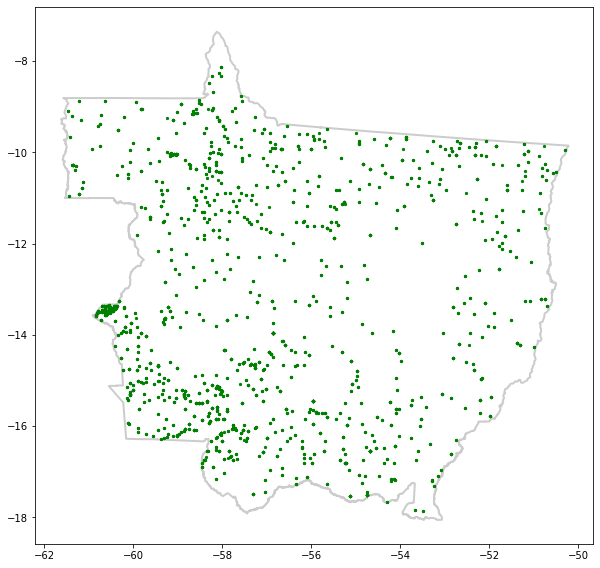

In [43]:
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(1, 1, 1)
ax = study_area.plot(ax=ax, linewidth=2, color='white', edgecolor='0.8')
sampling_points.plot(ax=ax, markersize=5, color='green');

In [44]:
# print the data crs
print(sampling_points.crs), print(study_area.crs)

epsg:4326
epsg:4326


(None, None)

In [ ]:
# # save the data the the current working directory
# image_list = [elevation_clip, slope_clip, landcover_clip, rainfall_clip,temp_clip,ndvi_clip, bsi_clip]
# out_folder = os.getcwd()


# for image in image_list:
#     print("Exporting image_name..........................................")
#     out_path = os.path.join(out_folder, 'elevation_clip.tif')
#     print(out_path)
#     if os.path.exists(out_path):
#         print(f'{image_name} already exists.')
#     else:
#         geemap.ee_export_image(image, out_path, scale=90, region=feature_cls)
#         print(f'{image_name} downloaded successfully to {out_path}.')

Reproject all data to the projected crs

In [54]:
#reproject th bounday shapefile
pro_boundary = study_area.to_crs(epsg=projected_crs)
print(pro_boundary.crs)

epsg:32721


In [55]:
#reproject the sampling points shapefiles
pro_sampling_points = sampling_points.to_crs(epsg=projected_crs)
print(pro_sampling_points.crs)

epsg:32721


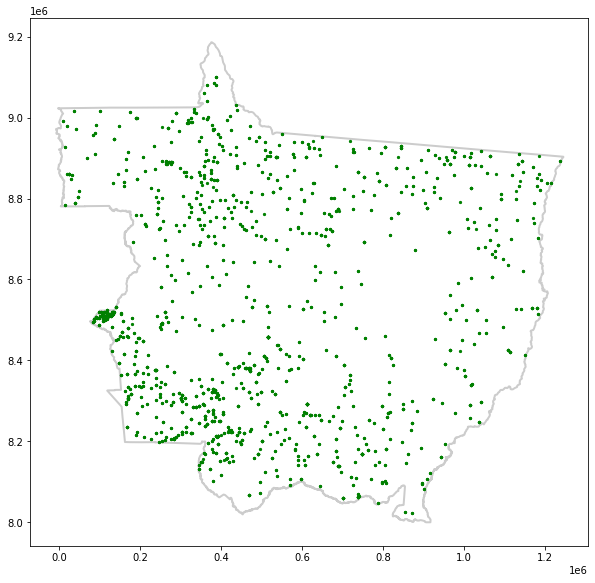

In [56]:
#plot reprojected raster
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(1, 1, 1)
ax = pro_boundary.plot(ax=ax, linewidth=2, color='white', edgecolor='0.8')
pro_sampling_points.plot(ax=ax, markersize=5, color='green');

In [58]:
from osgeo import gdal

In [72]:
#reproject all images
os.chdir(cwd) # change to current working folder
input_files = ['slope.tif', 'elevation.tif', 'landcover.tif', ]
output_res = (90, 90)

for file in input_files:
    input_file = os.path.join(cwd, file)
    output_file = os.path.join(cwd, f'projected_{file}')
    warp_options = gdal.WarpOptions(format='GTiff', xRes=output_res[0], yRes=output_res[1])
    gdal.Warp(output_file, input_file, options=warp_options)

In [75]:
import rasterio

Now, Load the Reprojected data into the Notebook and check the crs 

In [214]:
# # Load the slope, elevation, and land use rasters
# proj_slope = rasterio.open(os.path.join(cwd,'projected_slope.tif'),
#                       mode='r', driver="GTiff")
# proj_elevation =  rasterio.open(os.path.join(cwd,'projected_elevation.tif'),
#                          mode='r', driver="GTiff")
# proj_landuse = rasterio.open(os.path.join(cwd,'projected_landuse.tif'),
#                          mode='r', driver="GTiff")


# Load the slope, elevation, and land use rasters
slope = rasterio.open(os.path.join(cwd,'slope.tif'),
                      mode='r', driver="GTiff")
elevation  =  rasterio.open(os.path.join(cwd,'elevation.tif'),
                         mode='r', driver="GTiff")
land_use = rasterio.open(os.path.join(cwd,'landcover.tif'),
                         mode='r', driver="GTiff")

ndvi = rasterio.open(os.path.join(cwd,'ndvi.tif'),
                         mode='r', driver="GTiff")

bsi = rasterio.open(os.path.join(cwd,'bsi.tif'),
                         mode='r', driver="GTiff")

soil = rasterio.open(os.path.join(cwd,'soil.tif'),
                         mode='r', driver="GTiff")

images = [slope,elevation,land_use,ndvi,bsi, soil]
for image in images:
    print(f'{image}: {image.crs}')

<open DatasetReader name='C:\Users\HP\Desktop\Dr Chu\Matto Grosso\Data\slope.tif' mode='r'>: EPSG:4326
<open DatasetReader name='C:\Users\HP\Desktop\Dr Chu\Matto Grosso\Data\elevation.tif' mode='r'>: EPSG:4326
<open DatasetReader name='C:\Users\HP\Desktop\Dr Chu\Matto Grosso\Data\landcover.tif' mode='r'>: EPSG:4326
<open DatasetReader name='C:\Users\HP\Desktop\Dr Chu\Matto Grosso\Data\ndvi.tif' mode='r'>: EPSG:4326
<open DatasetReader name='C:\Users\HP\Desktop\Dr Chu\Matto Grosso\Data\bsi.tif' mode='r'>: EPSG:4326
<open DatasetReader name='C:\Users\HP\Desktop\Dr Chu\Matto Grosso\Data\soil.tif' mode='r'>: EPSG:4326


In [ ]:
# print(proj_slope.crs), print(proj_elevation.crs), print(proj_slope.crs)

### Now lets reproject our point data to the raster crs, extarct the values and also plot the raster data.

Since the raster crs is not mathcing with our training data points, to extract the values of each rasterdata to the points, we need to reproject the raster dataset to the flood dataset local datum (epsg:4326), this will make all the data overlay on each other.

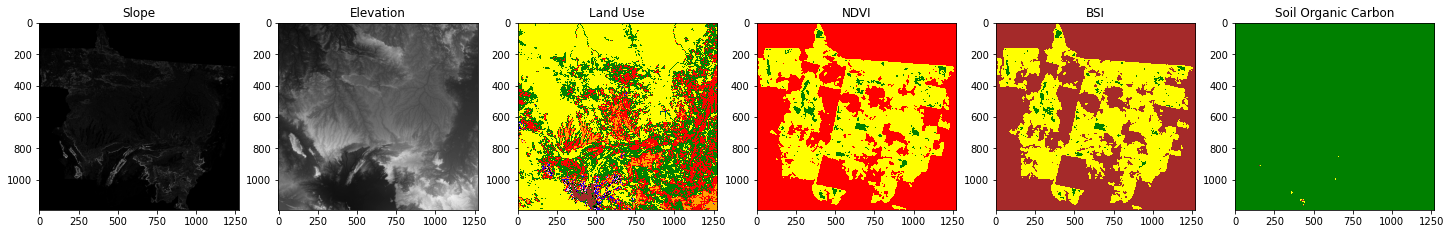

In [216]:
from matplotlib.colors import ListedColormap

# Get the raster data arrays and the coordinate reference systems (CRS) for each dataset
slope_data = slope.read(1)
elevation_data = elevation.read(1)
landuse_data = land_use.read(1)
ndvi_data = ndvi.read(1)
bsi_data = bsi.read(1)
soil_data = soil.read(1)

# Create a figure object and add three subplots
fig, axs = plt.subplots(1,6, figsize=(25, 10))

# Plot each raster dataset on a subplot
axs[0].imshow(slope_data, cmap='Greys_r')
axs[0].set_title('Slope')
axs[1].imshow(elevation_data, cmap='Greys_r')
axs[1].set_title('Elevation')
axs[2].imshow(landuse_data, cmap=ListedColormap([
      'yellow', 'green', 'red', 'orange', 'blue',
      'purple', 'pink', 'black', 'green', 'brown',
  ]))
axs[2].set_title('Land Use')
axs[3].imshow(ndvi_data, cmap=ListedColormap(['red', 'yellow', 'green']))
axs[3].set_title('NDVI')
axs[4].imshow(bsi_data, cmap=ListedColormap(['green', 'yellow', 'brown']))
axs[4].set_title('BSI')

axs[5].imshow(soil_data, cmap=ListedColormap(['green', 'yellow', 'brown']))
axs[5].set_title('Soil Organic Carbon')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the plot
plt.show()

Extract all the values from each raster dataset to the flood dataset
 To understand what each values of LULC represent got to https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200#bands

In [219]:
# Get the values of slope, elevation, and land use at the location of the random points
for index, point in sampling_points.iterrows():
    # Get the coordinates of the point
    x = point.geometry.x
    y = point.geometry.y
    
    # Get the row and column indices of the point in the rasters
    row, col = slope.index(x, y)
    
    # Extract the values of slope, elevation, and land use at the location of the point
    point_slope = slope.read(1)[row, col]
    point_elevation = elevation.read(1)[row, col]
    point_land_use = land_use.read(1)[row, col]
    point_ndvi = ndvi.read(1)[row, col]
    point_bsi = bsi.read(1)[row, col]
    point_soil = soil.read(1)[row, col]
  
    # Append the values to the point's attributes
    sampling_points.loc[index, 'slope'] = point_slope
    sampling_points.loc[index, 'elevation'] = point_elevation
    sampling_points.loc[index, 'land_use'] = point_land_use
    sampling_points.loc[index, 'ndvi'] = point_ndvi
    sampling_points.loc[index, 'bsi'] = point_bsi
    sampling_points.loc[index, 'SOC'] = point_soil

### Exploratory Data Analysis

Now lets explore our dataset, we will check for missing value, plor our data and also check the correlation between the dataset

In [220]:
# read the dataset to view the addeded columns
sampling_points.head()

,SOC_gkg,slope,elevation,land_use,ndvi,bsi,geometry,SOC
0,1.3,0.222091,241.0,10.0,0.068141,-0.035617,POINT (-51.30944 -14.21444),1.0
2,0.5,0.222091,241.0,10.0,0.068141,-0.035617,POINT (-51.30944 -14.21444),1.0
3,2.0,0.222091,241.0,10.0,0.068141,-0.035617,POINT (-51.30944 -14.21444),1.0
4,5.5,0.222091,241.0,10.0,0.068141,-0.035617,POINT (-51.30944 -14.21444),1.0
5,20.0,2.585801,468.0,30.0,0.477742,-0.393338,POINT (-52.80306 -14.51194),3.0


In [221]:
#check that there is no no data values in the dataset
print(sampling_points.head().isnull().sum())

SOC_gkg      0
slope        0
elevation    0
land_use     0
ndvi         0
bsi          0
geometry     0
SOC          0
dtype: int64


In [238]:
# read the dataset to view the addeded columns
sampling_points = sampling_points[['SOC_gkg','slope','elevation','ndvi','bsi','SOC','geometry']]
sampling_points.head()

,SOC_gkg,slope,elevation,ndvi,bsi,SOC,geometry
0,1.3,0.222091,241.0,0.068141,-0.035617,1.0,POINT (-51.30944 -14.21444)
2,0.5,0.222091,241.0,0.068141,-0.035617,1.0,POINT (-51.30944 -14.21444)
3,2.0,0.222091,241.0,0.068141,-0.035617,1.0,POINT (-51.30944 -14.21444)
4,5.5,0.222091,241.0,0.068141,-0.035617,1.0,POINT (-51.30944 -14.21444)
5,20.0,2.585801,468.0,0.477742,-0.393338,3.0,POINT (-52.80306 -14.51194)


In [239]:
#describe the dataset
sampling_points.describe()

,SOC_gkg,slope,elevation,ndvi,bsi,SOC
count,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000
mean,9.710639,1.027890,302.930242,0.188505,-0.165431,2.044817
std,11.171494,1.304667,134.114918,0.155726,0.128735,0.751307
min,0.100000,0.000000,97.000000,-0.014922,-0.669856,0.000000
25%,3.000000,0.314477,211.000000,0.059455,-0.238349,2.000000
50%,6.000000,0.697998,279.000000,0.150451,-0.138097,2.000000
75%,12.575000,1.203847,369.000000,0.280983,-0.082701,2.000000
max,122.400000,15.156256,864.000000,0.770654,0.031722,8.000000


In [240]:
sampling_points_2 = sampling_points[sampling_points.SOC_gkg>0]
sampling_points_2.describe()

,SOC_gkg,slope,elevation,ndvi,bsi,SOC
count,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000
mean,9.710639,1.027890,302.930242,0.188505,-0.165431,2.044817
std,11.171494,1.304667,134.114918,0.155726,0.128735,0.751307
min,0.100000,0.000000,97.000000,-0.014922,-0.669856,0.000000
25%,3.000000,0.314477,211.000000,0.059455,-0.238349,2.000000
50%,6.000000,0.697998,279.000000,0.150451,-0.138097,2.000000
75%,12.575000,1.203847,369.000000,0.280983,-0.082701,2.000000
max,122.400000,15.156256,864.000000,0.770654,0.031722,8.000000


The correlation map generated from my dataset showed that there is a strong positive correlation between the label and land use pattern, meaning that land use is a strong predictor of the label variable. The map also showed a high inverse correlation between elevation data and land use data, meaning that certain land use patterns are associated with different elevations. Additionally, there is a negative correlation between slope and elevation, indicating that areas with high slopes are likely to have lower elevations.

<AxesSubplot:>

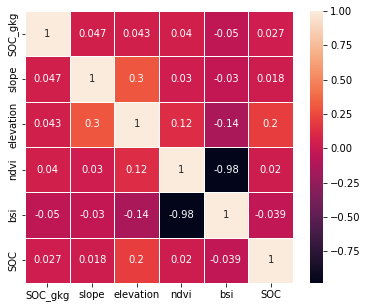

In [241]:
# show the correlation matric for the dataset
corrMatrix = sampling_points.corr()
fig, ax = plt.subplots(figsize=(6,5))         # Sample figsize in inches
#sns.heatmap(df.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)

In [230]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data2 = scaler.fit_transform(sampling_points_2.drop('geometry', axis=1))
data2

array([[-0.75301283, -0.6177487 , -0.46185998, ..., -0.77307322,
         1.00857998, -1.39093647],
       [-0.82463762, -0.6177487 , -0.46185998, ..., -0.77307322,
         1.00857998, -1.39093647],
       [-0.69034113, -0.6177487 , -0.46185998, ..., -0.77307322,
         1.00857998, -1.39093647],
       ...,
       [ 2.52382131, -0.23611265, -1.03610637, ..., -0.82966933,
         1.00888554, -1.39093647],
       [-0.78882522, -0.19564765, -0.46931772, ..., -0.04309957,
         0.1342108 , -1.39093647],
       [-0.64557564, -0.68022264, -0.59609939, ...,  1.44779882,
        -1.34246167,  1.27160958]])

In [234]:
df1 = pd.DataFrame(data=data2, columns=['SOC_gkg','slope','elevation','land_use','ndvi','bsi','SOC'])
df1.head()

,SOC_gkg,slope,elevation,land_use,ndvi,bsi,SOC
0,-0.753013,-0.617749,-0.461860,-0.819564,-0.773073,1.008580,-1.390936
1,-0.824638,-0.617749,-0.461860,-0.819564,-0.773073,1.008580,-1.390936
2,-0.690341,-0.617749,-0.461860,-0.819564,-0.773073,1.008580,-1.390936
3,-0.376983,-0.617749,-0.461860,-0.819564,-0.773073,1.008580,-1.390936
4,0.921217,1.194339,1.231048,0.344566,1.857708,-1.770702,1.271610


<AxesSubplot:>

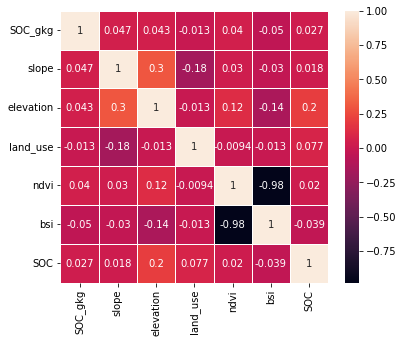

In [235]:
# show the correlation matric for the dataset
corrMatrix = df1.corr()
fig, ax = plt.subplots(figsize=(6,5))         # Sample figsize in inches
#sns.heatmap(df.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)

###  MACHINE LEARNING MODEL

* import the Ml libaries
* load the data
* split the data into dependent and independent variable
* splitt the dataset into training and test test
* Build our model uisng Random Forest Machine Learning Algorithm
* Check the accureacy of our model uisng differernt accracy metrics
* Plot the Predicted data
* Use the prediction  Probabaility output to create a raster map that shows probability of floodding across the study area

In [242]:
# import require libaries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [243]:
#load the dataset 
sampling_points.head()

,SOC_gkg,slope,elevation,ndvi,bsi,SOC,geometry
0,1.3,0.222091,241.0,0.068141,-0.035617,1.0,POINT (-51.30944 -14.21444)
2,0.5,0.222091,241.0,0.068141,-0.035617,1.0,POINT (-51.30944 -14.21444)
3,2.0,0.222091,241.0,0.068141,-0.035617,1.0,POINT (-51.30944 -14.21444)
4,5.5,0.222091,241.0,0.068141,-0.035617,1.0,POINT (-51.30944 -14.21444)
5,20.0,2.585801,468.0,0.477742,-0.393338,3.0,POINT (-52.80306 -14.51194)


In [237]:
sampling_points.to_csv('extracted.csv',index=False)

In [244]:
# Define the dependent variable that needs to be predicted (labels)
y = sampling_points["SOC_gkg"].values

# Define the independent variables. Let's also drop gemotry and label
x = sampling_points.drop(labels = ["SOC_gkg", "geometry"], axis=1) 
features_list = list(x.columns)  #List features so we can rank their importance later 

In [245]:
import random
random.seed(42)
#Split data into train (60 %), validate (20 %) and test (20%) to verify accuracy after fitting the model.
# training data is used to train the model
# validation data is used for hyperparameter tuning
# testing data is used to test the model

X_train_val, X_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2,shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25,shuffle=True, random_state=42)

#### RANDOM FOREST REGRESSION

In [246]:
# instantiate the Random Forest Model
model = RandomForestRegressor(n_estimators =1000, random_state = 42)

# Train the model on training data
model.fit(X_train, y_train)

# make prediction for the test dataset.
prediction = model.predict(X_test)

# The prediction SOC value
prediction[:10]

array([ 4.59193432,  8.86288379, 12.8210996 ,  3.85309554,  5.05213776,
       12.48945521,  2.63514694,  5.047127  , 14.02667072,  7.68878084])

In [247]:
y_test[:10]

array([ 3.20000005,  2.9       ,  6.5       ,  1.29999995,  5.6       ,
        4.        , 15.        , 10.80000019, 17.1       ,  3.1       ])

In [248]:
model.score(X_test,y_test)

-0.22408280175170048

#### Metric Evaluation

R2

In [201]:
r2_score(X_test,y_test)

ValueError: y_true and y_pred have different number of output (5!=1)

RMSE

MAE

In [202]:
mae = mean_absolute_error(y_test,prediction)
mae

7.3714412713829445

Features Importance

slope        0.263337
bsi          0.235133
elevation    0.234677
ndvi         0.224342
land_use     0.042511
dtype: float64


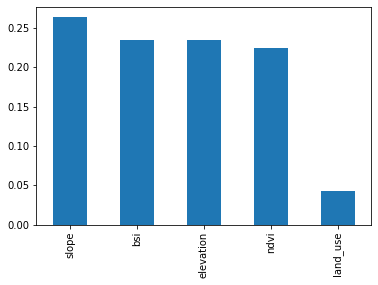

In [204]:
# Estimate the feature importance
feature_imp = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)
print(feature_imp)

# Plot the feature importance 
feature_imp.plot.bar();

Classification Accuracy

In [205]:
# Calculate the accuracy score
accuracy = r2_score(y_test, prediction)

# Print the accuracy as a percentage
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: -23.07%


### Evaluation of the results – include accuracy, ROC-AUC, feature importance and Accuracy 

In the context of machine learning, feature importance is a technique used to identify the most important predictors in a model. In this example, the feature importance scores for three predictors - elevation, slope, and land_use - were calculated using a random forest classifier. The results show that elevation is the most important predictor (with a score of 0.66), followed by slope (0.23) and land_use (0.11).

The random forest classifier achieved an AUC of 0.94, indicating that it has a high level of accuracy in distinguishing between the positive and negative classes. The accuracy of the model was also calculated and found to be 86.11%. This suggests that the model is able to accurately predict the target variable, which could be useful in a variety of applications.

Overall, the results of the feature importance analysis can help to identify the most important predictors in the model, which could be useful in guiding further research or decision-making. Additionally, the high accuracy of the model suggests that it may be a useful tool for predicting the target variable in other datasets.

### Generate 5000 new random points predictions points within the study area that will be use to predict if a location is floodeded or not

### Extract all the values from the independent raster data to the predictive random points

In [128]:
import random
from shapely.geometry import Point
random.seed(43)
# Define the number of random points you want to generate
num_points = 5000

# Generate the random points within the shapefile boundary
points = []
while len(points) < num_points:
    # Generate a random point within the extent of the boundary
    x = random.uniform(boundary.bounds.minx, boundary.bounds.maxx)
    y = random.uniform(boundary.bounds.miny, boundary.bounds.maxy)
    point = Point(x, y)
    
    # Check if the point is within the boundary
    if point.within(boundary.geometry.values[0]):
        points.append(point)

# Convert the list of points to a GeoDataFrame
crs = boundary.crs
predictive_points = gpd.GeoDataFrame(geometry=points, crs=crs)
predictive_points.head()

,geometry
0,POINT (-61.19297 -10.59732)
1,POINT (-59.99078 -13.09619)
2,POINT (-56.46278 -12.71402)
3,POINT (-57.38471 -8.92853)
4,POINT (-55.39277 -9.96545)


In [129]:
# Get the values of slope, elevation, and land use at the location of the random points
for index, point in predictive_points.iterrows():
    # Get the coordinates of the point
    x = point.geometry.x
    y = point.geometry.y
    
    # Get the row and column indices of the point in the rasters
    row, col = slope.index(x, y)
    
    # Extract the values of slope, elevation, and land use at the location of the point
    point_slope = slope.read(1)[row, col]
    point_elevation = elevation.read(1)[row, col]
    point_land_use = land_use.read(1)[row, col]
    
    # Append the values to the point's attributes
    predictive_points.loc[index, 'slope'] = point_slope
    predictive_points.loc[index, 'elevation'] = point_elevation
    predictive_points.loc[index, 'land_use'] = point_land_use
    
# read the dataset to view the addeded columns
predictive_points.head()

,geometry,slope,elevation,land_use
0,POINT (-61.19297 -10.59732),0.523963,174.0,30.0
1,POINT (-59.99078 -13.09619),2.563251,599.0,40.0
2,POINT (-56.46278 -12.71402),0.738486,359.0,10.0
3,POINT (-57.38471 -8.92853),0.174526,154.0,10.0
4,POINT (-55.39277 -9.96545),0.678743,257.0,10.0


In [130]:
# we need to remove all the columns except the predictive features
predicitve_data = predictive_points.drop(labels = ["geometry"], axis=1)
predicitve_data.head()

,slope,elevation,land_use
0,0.523963,174.0,30.0
1,2.563251,599.0,40.0
2,0.738486,359.0,10.0
3,0.174526,154.0,10.0
4,0.678743,257.0,10.0


### Finally, run the model on-some untrained data and present the results in a map

In order to map the flood susceptibility, this is the prediction for each ranmdoly generated points, each list has two values probability of being not flooded , probability of being flooded]

In [131]:
# predict if the location is flooded (1) or not flooded (0)
flood_prediction = model.predict(predicitve_data) 

In order to map the flood susceptibility we need to cacluate the probability of being flooded.

In [132]:
flood_probability =model.predict_proba(predicitve_data) 

AttributeError: 'RandomForestRegressor' object has no attribute 'predict_proba'

In [134]:
# We need the classification info as well as the probablity of each location being flooded
# We need to add the value coressponding to each point
predictive_points['flood_prediction']= flood_prediction [:]
# predictive_points['flood_probability']= flood_probability [:,1]

In [135]:
predictive_points.head()

,geometry,slope,elevation,land_use,flood_prediction
0,POINT (-61.19297 -10.59732),0.523963,174.0,30.0,9.900764
1,POINT (-59.99078 -13.09619),2.563251,599.0,40.0,16.081838
2,POINT (-56.46278 -12.71402),0.738486,359.0,10.0,12.551012
3,POINT (-57.38471 -8.92853),0.174526,154.0,10.0,3.623183
4,POINT (-55.39277 -9.96545),0.678743,257.0,10.0,14.957310


Generate the Raster data showing of the Flood Probabilty

In [136]:
# Converting the point shapefile to raster.
# We will use the model prediction (column flood_probability in predictive_points to make a raster)
from geocube.api.core import make_geocube
import rasterio as rio

grid_data = make_geocube(vector_data=predictive_points_pro, measurements=["flood_probability"],interpolate_na_method='linear', resolution=(-30, 30))
grid_data["flood_probability"].rio.to_raster("Flood_susceptibility.tif")

ModuleNotFoundError: No module named 'geocube'

In [137]:
from rasterio.plot import show
from matplotlib.colors import ListedColormap, BoundaryNorm

# Open the raster file
Flood_susceptibility = rasterio.open(os.path.join(cwd,'Flood_susceptibility.tif'), mode='r', driver="GTiff")

# clip the raster to its extent
clipped_flood_map, clipped_transform = rasterio.mask.mask(Flood_susceptibility , 
                                                      Bonaventure_boundary.geometry,
                                                      crop=True,
                                                      nodata=None, 
                                                      filled = False)


# Display the clipped flood susceptibility map with the new color map
fig, ax = plt.subplots(figsize=(15, 12))
show(clipped_flood_map, ax=ax, cmap='coolwarm')
ax.set_title('Flood Susceptibility Map')

RasterioIOError: C:\Users\HP\Desktop\Dr Chu\Matto Grosso\Data\Flood_susceptibility.tif: No such file or directory

In [138]:
# you can save the flood prediction data if you want
predictive_points.to_file('soc_pred.geojson', driver="GeoJSON")

CRSError: Invalid input to create CRS: GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]

ESA WorldCover v200. (n.d.). Google Earth Engine. February 25, 2023, from https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200#bands

Geemap. (n.d.). GitHub. Retrieved February 25, 2023, from https://github.com/giswqs/geemap/blob/master/examples/notebooks/geemap_and_earthengine.ipynb#scrollTo=No26yd0bcRZ1

Hatarilabs. (2020, January 15). How to reproject single and multiple rasters with Python and Rasterio [Tutorial]. February 25, 2023, from https://hatarilabs.com/ih-en/how-to-reproject-single-and-multiple-rasters-with-python-and-rasterio-tutorial

Sudipta, P. (2021, May 20). Zonal statistics with Google Earth Engine. Retrieved September 15, 2021, from https://geemap.org/notebooks/12_zonal_statistics/

World Bank. (n.d.). Import and export data [Tutorial]. Retrieved February 25, 2023, from https://worldbank.github.io/OpenNightLights/tutorials/mod3_7_import_export_data.html

Towards urban flood susceptibility mapping using machine and deep learning models [Blog post]. Hydroinformatics. Retrieved September 15, 2021, from https://medium.com/hydroinformatics/towards-urban-flood-susceptibility-mapping-using-machine-and-deep-learning-models-3-random-9fe4e1279f3b